In [ ]:
# torch.nn.functional中有很多功能，后续会常用。那么什么是用nn.Module，什么时候用nn.functional呢
# 一般情况下，如果 模型有可学习的参数，最好用nn.Module，其他情况用nn.functional更简单一些
# MSB:可以认为是大端存储
# python中的...省略号,表示索引操作时省略冒号 a[:,:,1] = a[...,1]


In [ ]:
'''
TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).

TEST SET LABEL FILE (t10k-labels-idx1-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  10000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

TEST SET IMAGE FILE (t10k-images-idx3-ubyte):
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  10000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel
Pixels are organized row-wise. Pixel values are 0 to 255. 0 means background (white), 255 means foreground (black).
'''

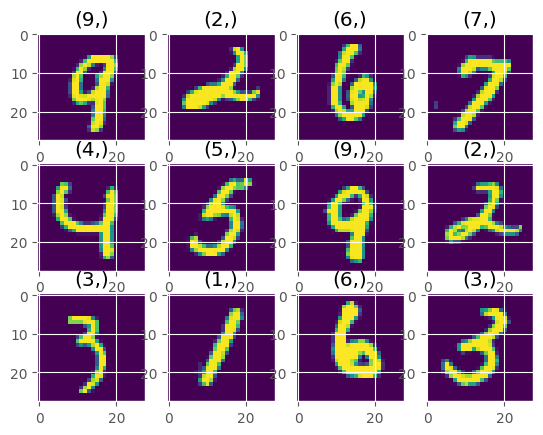

In [15]:
%matplotlib inline
import numpy as np
import gzip
import struct
import matplotlib.pyplot as plt

mnist = {
    'trainset'  :'d:/GitRepos/data/MNIST/train-images-idx3-ubyte.gz',
    'trainlabel':'d:/GitRepos/data/MNIST/train-labels-idx1-ubyte.gz',
    'testset'   :'d:/GitRepos/data/MNIST/t10k-images-idx3-ubyte.gz',
    'testlabel' :'d:/GitRepos/data/MNIST/t10k-labels-idx1-ubyte.gz'
}
image_header = {
    'magic' :0,
    'cnt'   :0,
    'rows'  :0,
    'cols'  :0
}
label_header = {
    'magic'  :0,
    'itemNum':0
}

def get_header(path : str,header_fmt : str):
    offset = 0
    # fmt = '>{}i'.format(head_size)
    with gzip.open(path) as f:
        bytescontent = f.read()
        h_list = [x for x in struct.unpack_from(header_fmt,bytescontent,offset=offset)]
        keys   = [k for k in image_header.keys()]
        header = dict(zip(keys,h_list))
    return header

# offset : starting position
# format : asigning size of bytes
def image_loader_idx3(path : str,header_fmt : str,header : dict,yield_batch_idx : int,yield_batch_size : int):
    # 
    assert yield_batch_idx  > 0
    assert yield_batch_size > 0
    # header offset,use struct.calcsize() to get the correct offset caused by aligning
    offset_head = struct.calcsize(header_fmt)
    size_image = header['rows'] * header['cols']
    # batch offset
    fmt_batch = '{}B'.format((yield_batch_idx-1) * yield_batch_size * size_image)
    offset_batch = struct.calcsize(fmt_batch)
    # single image offset
    fmt_image = '>{}B'.format(size_image)
    with gzip.open(path) as f:
        bindata = f.read()
        images_list = (
            np.array(
            struct.unpack_from(
                fmt_image,
                bindata,
                offset= struct.calcsize(fmt_image) * i + offset_head + offset_batch
                )
            ).reshape(header['rows'],header['cols'])
            for i in range(yield_batch_size)
        )
    return images_list

def label_loader_idx1(path : str,header_fmt : str,yield_batch_idx : int,yield_batch_size : int):
    #
    assert yield_batch_idx  > 0
    assert yield_batch_size > 0
    # head offset
    offset_head = struct.calcsize(header_fmt)
    # batch offset
    fmt_batch = '{}B'.format((yield_batch_idx - 1) * yield_batch_size * 1)
    offset_batch = struct.calcsize(fmt_batch)
    fmt = '>B'
    with gzip.open(path) as f:
        bindata = f.read()
        labels_list =(
            struct.unpack_from(
            fmt,
            bindata,
            offset=offset_head + struct.calcsize(fmt) * i + offset_batch
            )
            for i in range(yield_batch_size)
        )
    return labels_list

image_header = get_header(path=mnist['trainset'],header_fmt='>4i')
label_header = get_header(path=mnist['trainlabel'],header_fmt='>2i' )

# form a new header
yield_batch_idx = 9
yield_batch_size = 100

header_fmt_image = '>4i'
header_fmt_label = '>2i'

train_image_loader = image_loader_idx3(path=mnist['trainset'],header_fmt=header_fmt_image,header=image_header,yield_batch_idx=yield_batch_idx,yield_batch_size=100)
train_label_loader = label_loader_idx1(path=mnist['trainlabel'],header_fmt=header_fmt_label,yield_batch_idx=yield_batch_idx,yield_batch_size=100)

# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
# print(list(image_loader)[0].shape, plt.style.available)

plt.style.use('ggplot')
fig, axs = plt.subplots(nrows=3,ncols=4)
for ax in axs:
    for a in ax:
        a.set_title('{}'.format(next(train_label_loader)))
        # print(next(train_label_loader))
        a.imshow(next(train_image_loader))



In [ ]:
import torch
